# Virtual Environment with Brainy Boids

#### Brainy Boid description
Brainy Boid can move 1 pixel in any direction every period. It possess a neural network to act as a 'brain' to decide where it will move based on its vision (a square with default radius of 3). Energy is consumed every period (amount depending on whether the boid attempts to move) and the boid will die if energy reaches 0.

#### Env
Environment is represented by a class with food and boids being a subclass

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import time
import random
import sys

from math import copysign # used to generate sign of integer (1 or -1)
from IPython.display import clear_output # allows jupyter to clear output using code

np.set_printoptions(linewidth=500)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.set_printoptions(threshold=sys.maxsize) # allows jupyter to show full numpy array

%matplotlib inline

## Environment

In [2]:
class Environment:
    
    def __init__(self, width, height, food_overlap=False, display_size=[7, 7]):
        # Env basic parameters
        self.width = width
        self.height = height
        # default values
        self.display_size = display_size
        self.food_overlap = food_overlap
        # env attributes to run functions
        self.map = np.zeros((width, height))
        self.frame = 0
        self.food_locs = []
        self.boid_list = []

        
    def reset_all(self):
        self.map = np.zeros((width, height))
        self.frame = 0
        
        
    def reset_frames(self):
        self.frame = 0
        
        
    def change_display_size(self, size):
        self.display_size = size
        
        
    def display_frame(self, delay, print_below=None):
        display_array = np.array((self.width, self.height, 3), 240)
        
        self.frame += 1
        
        print('Frame: ', self.frame)
        fig, ax = plt.subplots(figsize=tuple(self.display_size))
        ax.set_axis_off()
        ax.matshow(self.map.T, origin='lower')
        plt.pause(0.001)
        
        if print_below != None:
            for string in print_below:
                print(string)
        
        time.sleep(delay)
        
    
   ### Food functions
    def add_food_random(self, num_food):
        food_added = 0
        if self.food_overlap:
            while food_added < num_food:
                new_food_loc = [random.randint(0, self.width - 1), random.randint(0, self.height - 1)]
                self.food_locs.append(new_food_loc)
                self.map[tuple(new_food_loc)] += 1
                food_added += 1
        else:
            while food_added < num_food:
                new_food_loc = [random.randint(0, self.width - 1), random.randint(0, self.height - 1)]
                if new_food_loc not in self.food_locs:
                    self.food_locs.append(new_food_loc)
                    self.map[tuple(new_food_loc)] += 1
                    food_added += 1
                
                
    def add_food_loc(self, loc):
        # if food overlapping is turned on
        if self.food_overlap:
            if loc in [boid.loc for boid in self.boid_list]:
                print('Invalid location: Boid exists here')
            else:
                self.food_locs.append(loc)
                self.map[tuple(loc)] += 1
        # if food overlapping is turned off
        else:
            if loc in self.food_locs:
                print('Invalid location: Food exists here')
            elif loc in [boid.loc for boid in self.boid_list]:
                print('Invalid location: Boid exists here')
            else:
                self.food_locs.append(loc)
                self.map[tuple(loc)] += 1
                
        
    def remove_food_loc(self, loc):
        self.food_locs.remove(loc)
        self.map[tuple(loc)] -= 1

    
   ### Boid functions
    # add boid loc to environment's boid_locs list
    def add_boid(self, boid):
        self.boid_list.append(boid)
        self.map[tuple(boid.loc)] += 5
        
        
    # remove boid from environment given the boid
    def remove_boid(self, boid):
        self.boid_list.remove(boid)
        self.map[tuple(boid.loc)] -= 5
        
        
    # remove boid from environment given boid location
    def remove_boid_loc(self, loc):
        for boid in self.boid_list:
            if boid.loc == loc:
                self.map[tuple(boid.loc)] -= 5
                self.boid_list.remove(boid)
                break

## Boid

In [3]:
class BrainyBoid():
    
    def __init__(self, boid_env, name, start_loc=None, if_occupied='replace', collision='bump', edge='wall', starting_energy=100):
        ### Boid basic parameters
        self.boid_env = boid_env   # boid_env is a Environment object
        self.name = name
        
        ## starting location
        # if starting location is not specified, it is randomly generated
        if start_loc == None:
            # if starting location is not empty, new starting location is generated
            while True:
                self.loc = [random.randint(0, boid_env.width - 1), random.randint(0, boid_env.width - 1)]
                if boid_env.map[tuple(self.loc)] == 0:
                    break
                    
        # if it is specified, set location to start_loc and check if location is already occupied
        else:
            self.loc = start_loc
            # check if starting location is occupied
            if boid_env.map[tuple(self.loc)] != 0:
                # save value of object in the occupied location
                occupying_object_val = boid_env.map[tuple(self.loc)]
                print('Starting location is occupied: value =', occupying_object_val)
                
                # generate new random location that is not occupied
                if if_occupied == 'random':
                    print('New random starting location is being generated')
                    while True:
                        self.loc = [random.randint(0, boid_env.width - 1), random.randint(0, boid_env.width - 1)]
                        if boid_env.map[tuple(self.loc)] == 0:
                            break
                            
                # remove the object in the location
                elif if_occupied == 'replace':
                    print('Replacing object in location')
                    if occupying_object_val == 1:
                        boid_env.remove_food_loc(self.loc)
                    if occupying_object_val == 5:
                        boid_env.remove_boid_loc(self.loc)
                    
        # add new boid to environment
        boid_env.add_boid(self)
        
        ### Default values
        self.collision = collision
        self.edge = edge
        self.if_occupied = if_occupied
        
        ### Boid attr to run functions
        self.food_eaten = 0   # total food eaten across lifetime
        self.energy = starting_energy   # default 100
        self.status = 'alive'
        self.age = 0   # number of periods this boid has stayed alive
        
        
   ### Location Functions
    def set_loc(self, loc):
        new_loc_val = self.boid_env.map[tuple(loc)]
        if new_loc_val != 0:
            print('Specified location is occupied: value =', new_loc_val)
            if self.if_occupied == 'replace':
                # remove existing object in specified location
                if new_loc_val == 1:
                    self.boid_env.remove_food_loc(loc)
                if new_loc_val == 5:
                    self.boid_env.remove_boid_loc(loc)
                # then add boid in that location
                self.boid_env.map[tuple(self.loc)] -= 5
                self.loc = loc
                self.boid_env.map[tuple(loc)] += 5
            else:
                print('Please specify new location')
        # if new location is unoccupied
        else:
            self.boid_env.map[tuple(self.loc)] -= 5
            self.loc = loc
            self.boid_env.map[tuple(loc)] += 5
            
    def info(self):
        name = 'Boid Name: ' + str(self.name)
        location = 'Location: ' + str(self.loc)
        energy = 'Energy: ' + str(self.energy)
        age = 'Age: ' + str(self.age)
        food_eaten = 'Food Eaten: ' + str(self.food_eaten)
        status = 'Status: ' + str(self.status)
        return '  '.join([name, location, energy, age, food_eaten, status])

#### Check Environment and BrainyBoid Works

Frame:  11


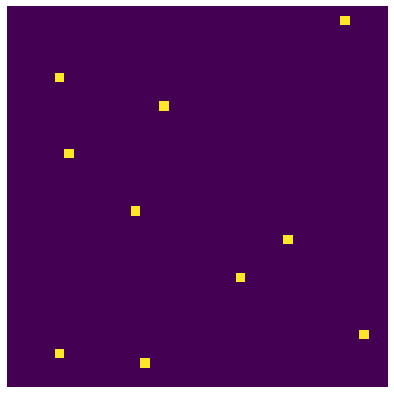

In [5]:
# Test __init__(), add_food_random(), and display_frame()
env = Environment(40, 40)
env.display_frame(2)
clear_output(wait=True)
for _ in range(10):
    env.add_food_random(1)
    env.display_frame(0.5)
    clear_output(wait=True)

Frame:  6


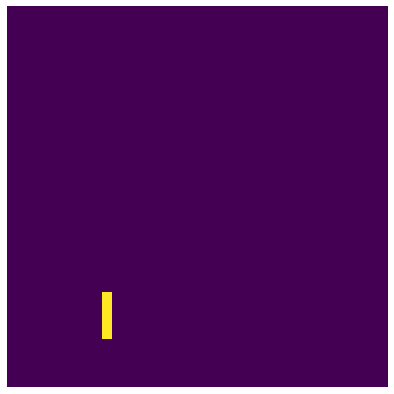

In [62]:
# Test add_food_loc
env = Environment(40, 40)

food_locations = [[10, x] for x in range(5, 10)]
print('Number of food to add: ', len(food_locations))

env.display_frame(2)
clear_output(wait=True)

for food_coor in food_locations:
    env.add_food_loc(food_coor)
    env.display_frame(0.5)
    clear_output(wait=True)

Remove Boid
Frame:  5


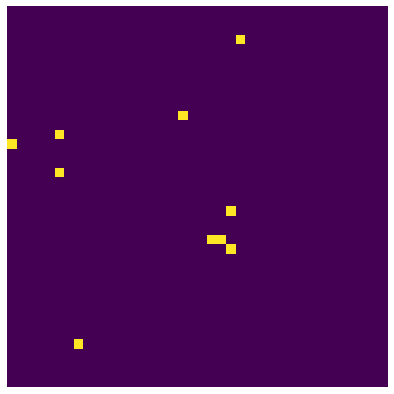

In [6]:
# Test boid __init__() and set_loc()
env = Environment(40, 40)
frame_speed = 1.5

# Environment
print('Empty Environment')
env.display_frame(frame_speed*2)
clear_output(wait=True)

env.add_food_random(10)

print('Environment with Food')
env.display_frame(frame_speed)
clear_output(wait=True)

# Boid
boid1 = BrainyBoid(env, 'boid1')

print('Initialise Boid')
print(boid1.info())
env.display_frame(frame_speed)
clear_output(wait=True)


# set location of boid
new_loc = [10, 10]
boid1.set_loc(new_loc)

print('Set Location to', new_loc)
print(boid1.info())
env.display_frame(frame_speed)
clear_output(wait=True)


# remove boid
env.remove_boid(boid1)

print('Remove Boid')
env.display_frame(frame_speed)


### Test

In [47]:
class Parent():
    
    def __init__(self):
        self.attr = 15
        self.children = []
    
    def change_attr(self, num):
        self.attr = num
        
    def print_something(self):
        print('something')
        
    def add_child(self, child):
        self.children.append(child)
        
        
class Child():
    
    def __init__(self, name, parent):
        self.name = name
        self.parents = [parent]
        parent.add_child(self)
        

    def add_parent(self, parent):
        self.parents.append(parent)
        
    def change_par_attr(self,num):
        self.par.attr = num
        
    
    
    
        
parent1 = Parent()
child1 = Child('child1', parent1)
child2 = Child('child2', parent1)

for child in parent1.children:
    print('Parent1 child: ', child.name)



Parent1 child:  child1
Parent1 child:  child2


In [48]:
child3 = Child('child3', parent1)
child4 = Child('child4', parent1)

for child in parent1.children:
    print('Parent1 child: ', child.name)

Parent1 child:  child1
Parent1 child:  child2
Parent1 child:  child3
Parent1 child:  child4


## Manual Brain Test

## Test to generate image

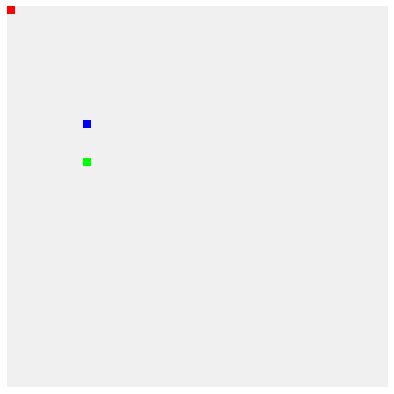

In [34]:
from PIL import Image

test_array = np.zeros((50, 50, 3), dtype=np.uint8)
test_array.fill(240)
red_rgb = [255, 0, 0]
green_rgb = [0, 255, 0]
blue_rgb = [0, 0, 255]
test_array[0, 0] = red_rgb
test_array[15, 10] = blue_rgb
test_array[20, 10] = green_rgb

img = Image.fromarray(test_array, 'RGB')


#fig = plt.imshow(np.asarray(img_resized))

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_axis_off()
ax.imshow(np.asarray(img))
plt.pause(0.001)

In [40]:
display_array = np.full_like(np.zeros((40, 40, 3)), 240)
print(display_array.shape)

(40, 40, 3)
